# Cross-Validation of `lm` model

Make a k-fold cross-validation using natural years. _Leave-one-(natural year)-out_

In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(openair))

suppressMessages(library(caret))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

## Representative sample 

In [4]:
sites.lv <- c("es0118a", "es1438a") # Big cities (Madrid and Barcelona)",
sites.lv <- c(sites.lv, "es1580a", "es1340a") # small cities (Santander and Huelva)

## DataFrame Creation

In [5]:
# Create dataSet
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01")
                  ) %>%
            timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto %>%
            filter(site %in% sites.lv,
                   date < ymd("2020-01-01"))

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        mutate_if(is.factor, as.character) %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)

## PreProcess

In [6]:
deseason <- function(cl) {
    # Remove seasonal component of the additive time serie.
    #     This function is called below by an apply
    
    dcomp <- decompose(ts(cl, frequency = 365))

    cl - dcomp$seasonal
}

scale.df <- function(df, omit.cl) {
    # Scale dataframe ignoring no numeric columns (omit.cl)
    
    df[, omit.cl] <- scale(df[, omit.cl])
    df
}

## Cross-Validation

In [7]:
leave.one.year.out <- function(yr, dat, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(dat$date) == yr)
    train <- which(year(dat$date) != yr)

    if(length(test) == 0 | length(train) == 0) {
        return
    }

    model <- train(value ~., 
                   data=dat[, omit.cl], subset=train,
                   method="lm"
                  )

    y.th <- predict(model, newdata=dat[test,])
    
    data.frame("bias"=mean(y.th) / mean(dat[test,]$value),
               "var.ratio"=var(y.th) / var(dat[test,]$value),
               "cor"=cor(y.th, dat[test,]$value, method = "pearson")
              )
}

In [8]:
years <- 2013:2019

no.num.cl <- 1:3 # no numeric columns 
cv.df <- data.frame()

# Create one model for each pair of station-pollutant
for (st in sites.lv) {
    data.st <- df[df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        dat <- data.st[data.st$variable == pll, ]
        
        if (sum(!is.na(dat$date)) > (365*2)) {
            # if there is enough data (more than 2 years), deseasonalized
            dat <- cbind(dat[, no.num.cl],
                         apply(dat[, -no.num.cl], 2, deseason))
        }
        
        ds.dat <- scale.df(dat, -no.num.cl)
        
        cv.row <- do.call(rbind, lapply(years, leave.one.year.out,
                                        ds.dat, -no.num.cl))

        cv.df <- rbind(cv.df,
                       cbind(data.frame("variable"=pll,
                                        "site"=st),
                             rbind(colMeans(cv.row, na.rm=T)))
                       )
    }
}

In [9]:
cv.df

variable,site,bias,var.ratio,cor
<chr>,<chr>,<dbl>,<dbl>,<dbl>
no,es0118a,-0.14136644,0.2872377,0.5034979
no2,es0118a,0.09571740,0.3945300,0.5538545
o3,es0118a,-0.26766466,0.2955504,0.5139946
pm10,es0118a,0.32756411,0.2676025,0.4979025
pm2.5,es0118a,-3.38374682,0.2814067,0.5133461
no,es1438a,-0.35775404,0.1892350,0.3992271
no2,es1438a,-0.02413955,0.2683977,0.5052044
o3,es1438a,-1.01859448,0.5414922,0.6516124
no,es1580a,-4.26339735,0.2474601,0.4518363


In [10]:
mean.cv.df <- cv.df %>%
                group_by(variable) %>%
                summarise(var.ratio=mean(var.ratio),
                          bias=mean(bias),
                          cor=mean(cor)
                         ) %>%
                print()

# A tibble: 5 x 4
  variable var.ratio    bias   cor
* <chr>        <dbl>   <dbl> <dbl>
1 no           0.249 -6.73   0.461
2 no2          0.366  0.0422 0.548
3 o3           0.419 -0.643  0.583
4 pm10         0.234 -0.113  0.431
5 pm2.5        0.281 -3.38   0.513


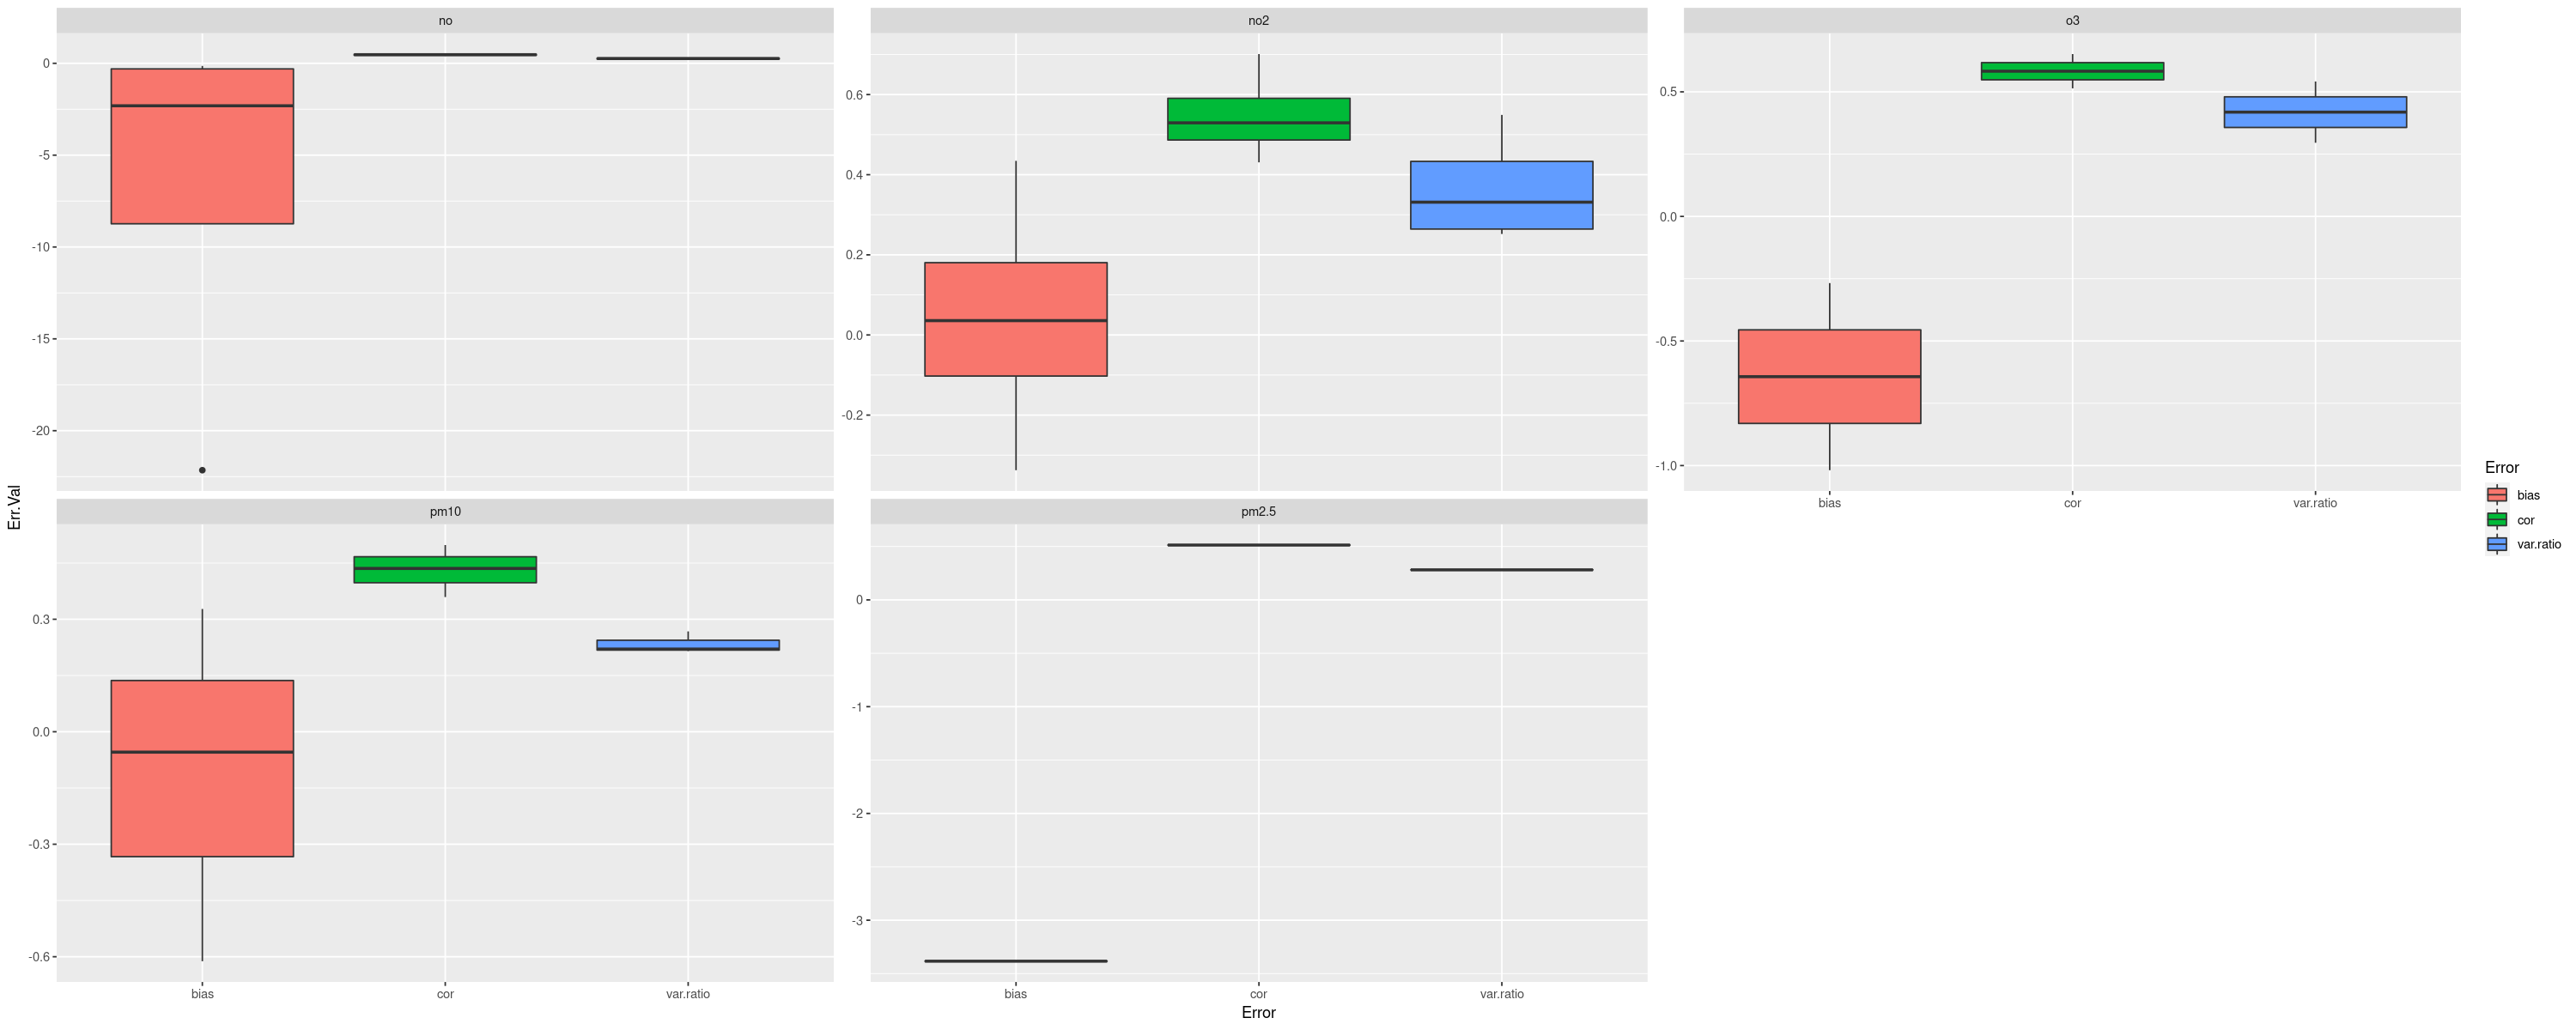

In [11]:
pivot.cv.df <- cv.df %>%
        pivot_longer(cols = c(3:ncol(cv.df)), 
                     names_to = "Error", values_to = "Err.Val")

ggplot(data=pivot.cv.df, aes(x=Error, y=Err.Val, fill=Error)) +
        geom_boxplot() + 
        facet_wrap(~variable, scales = "free_y")